In [1]:
import os
import sys
from pathlib import Path

# Automatically find the project root (where "src/" and "saved_weights/" exist)
def find_project_root(marker_dirs=("src", "saved_weights")):
    path = Path.cwd()
    while path != path.parent:
        if all((path / d).exists() for d in marker_dirs):
            return path
        path = path.parent
    raise RuntimeError("Project root not found. Are you inside the mils-pruning directory tree?")

project_root = find_project_root()
os.chdir(project_root)
sys.path.insert(0, str(project_root / "src"))  # ensures mils_pruning is importable

print(f"Working directory set to: {os.getcwd()}")


Working directory set to: /Users/eyujisgmail.com/Documents/mils-pruning


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from mils_pruning import BinarizedMLP, train, EarlyStopping, get_mnist_data_loaders


In [3]:
num_runs = 10  # You can change this to any number
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
nodes_h1 = 32
nodes_h2 = 32 

In [5]:
# Create data loaders once with fixed splits
train_loaders, val_loader, test_loader = get_mnist_data_loaders(num_runs=num_runs)

In [6]:
# seeds = list(range(num_runs))

# # Define architecture parameters first
# nodes_h1 = 32
# nodes_h2 = 32
# arch_tag = f"arch_{nodes_h1}_{nodes_h2}"

# for run_idx, seed in enumerate(seeds):
#     torch.manual_seed(seed)
#     np.random.seed(seed)

#     model = BinarizedMLP(input_shape=(10, 10), nodes_h1=nodes_h1, nodes_h2=nodes_h2).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss()
#     early_stopping = EarlyStopping(patience=5, min_delta=0)

#     # Use arch_tag and run index to form experiment_id
#     experiment_id = f"{arch_tag}_run{run_idx}"

#     train(
#         model=model,
#         train_loader=train_loaders[run_idx],
#         val_loader=val_loader,
#         optimizer=optimizer,
#         criterion=criterion,
#         early_stopping=early_stopping,
#         epochs=50,
#         device=device,
#         experiment_id=experiment_id
#     )


In [ ]:
from mils_pruning import run_node_pruning_experiments

run_node_pruning_experiments(
    arch_tag="arch_32_32",
    num_runs=10,
    max_removal_ratio=0.25,
    prune_step=1,
    strategies=[
        "min_increase", "max_increase",
        "min_absolute", "max_absolute",
        "min_decrease", "max_decrease"
    ],
    test_loader=test_loader,
    device=device
)


Pruning (random_run1):  95%|█████████▍| 18/19 [00:06<00:00,  2.70it/s]

In [34]:
from mils_pruning import run_weight_pruning_experiments

run_weight_pruning_experiments(
    arch_tag="arch_32_32",
    num_runs=10,
    max_removal_ratio=0.10,
    prune_step=1,
    strategies=[
        "min_increase", "max_increase",
        "min_absolute", "max_absolute",
        "min_decrease", "max_decrease"
    ],
    test_loader=test_loader,
    device=device
)


AssertionError: Unknown pruning level: weights

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
from mils_pruning.paths import get_result_file


def load_all_runs(arch_tag, level, name_prefix, num_runs):
    acc_matrix, activity_matrix = [], []
    for i in range(num_runs):
        acc = np.load(get_result_file(arch_tag, level, f"{name_prefix}_run{i}", "accs"))
        activity = np.load(get_result_file(arch_tag, level, f"{name_prefix}_run{i}", level + "s"))
        acc_matrix.append(acc)
        activity_matrix.append(activity)
    return np.array(acc_matrix), np.array(activity_matrix)


def plot_averaged_results(arch_tag, level, names, num_runs, sigma=1, show_ci=True):
    """
    Plot averaged accuracy curves (with optional 95% confidence interval) for a given level.

    Parameters
    ----------
    arch_tag : str
        e.g., "arch_32_32"
    level : str
        "node" or "weight"
    names : list of str
        List of experiment name prefixes (without "_runX").
    num_runs : int
        Number of runs per experiment.
    sigma : float
        Smoothing factor for accuracy curve.
    show_ci : bool
        Whether to show shaded 95% confidence intervals.
    """
    assert level in {"node", "weight"}, f"Invalid level: {level}"
    suffix = "Nodes" if level == "node" else "Weights"

    plt.figure(figsize=(10, 6))

    for name in names:
        accs, activity = load_all_runs(arch_tag, level, name, num_runs)

        mean = accs.mean(axis=0)
        std = accs.std(axis=0)
        ci95 = 1.96 * std / np.sqrt(num_runs)

        mean_smooth = gaussian_filter1d(mean, sigma=sigma)
        ci95_smooth = gaussian_filter1d(ci95, sigma=sigma)

        plt.plot(activity[0], mean_smooth, label=name, linewidth=2)

        if show_ci:
            plt.fill_between(activity[0], mean_smooth - ci95_smooth, mean_smooth + ci95_smooth, alpha=0.2)

    plt.xlabel(f"Active {suffix}")
    plt.ylabel("Test Accuracy (%)")
    plt.title(f"Average Accuracy vs Pruned {suffix}" + (" (with 95% CI)" if show_ci else ""))
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


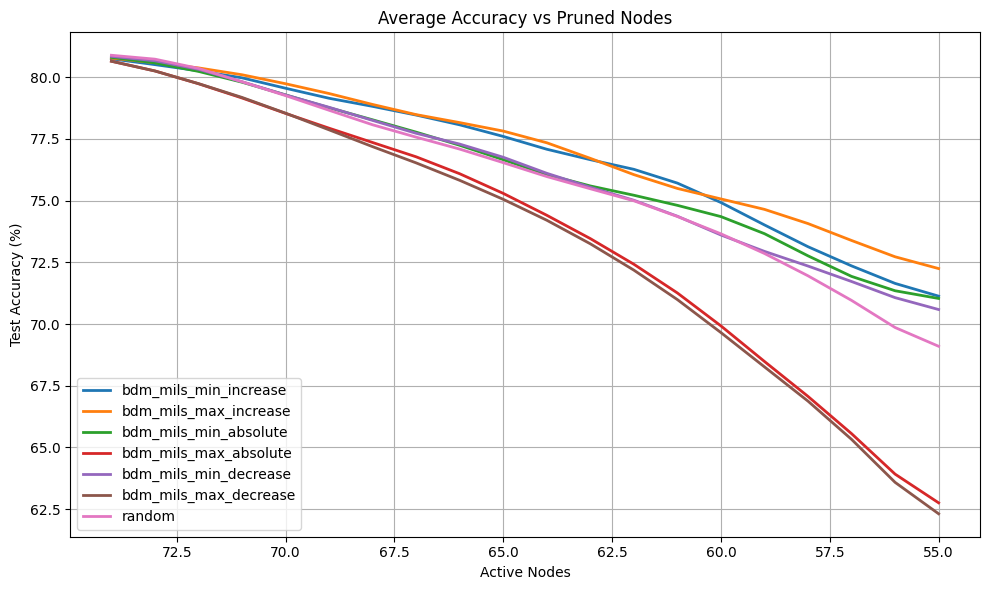

In [ ]:
plot_averaged_results(
    arch_tag="arch_32_32",
    level="node",
    names=[
        "mils_min_increase", "mils_max_increase",
        "mils_min_absolute", "mils_max_absolute",
        "mils_min_decrease", "mils_max_decrease",
        "random"
    ],
    num_runs=10,
    sigma=1,
    show_ci=True
)